# Structural Details: Kinase Conformation
as determined by the KinCore standalone python script, by Modi and Dunbrack <br> <br> 
*References* <br> 
- https://github.com/vivekmodi/Kincore-standalone/tree/master 
- http://dunbrack.fccc.edu/kincore/webserver 
- V. Modi and R.L, Dunbrack, Kincore: a web resource for structural classification of protein kinases and their inhibitors, Nucleic Acids Research, Volume 50, Issue D1, 7 January 2022, Pages D654–D664, https://doi.org/10.1093/nar/gkab920

`./batch_run_kincore_standalone_modified.sh`

In [1]:
import os
import glob
import pandas as pd
pd.set_option('display.max_rows', 100)
pd.set_option("display.max_columns", 200)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', None)
from rdkit.Chem import PandasTools, AllChem, Descriptors, Draw

In [2]:
# Find the latest created .txt file in the directory specified, with naming pattern "kincore_results_"
latest_file = max(glob.glob(os.path.join('Analysis/Kinase_Conformation/', 'kincore_results_*.tsv')), key=os.path.getctime)
print(latest_file)

# Read the file into a Pandas DataFrame
df = pd.read_csv(latest_file, sep='\t', header=None)

df.head(3)

Analysis/Kinase_Conformation/kincore_results_2025-02-09_12-02-13.tsv


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
0,NaN,Input,Group,Model,Chain,Spatial_label,Dihedral_label,C-helix_label,Ligand,Ligand_label,X-DFG,Φ,Ψ,DFG-Asp,Φ,Ψ,DFG-Phe,Φ,Ψ,χ1,NaN
1,NaN,1CDK.pdb,AGC,0,A,DFGin,BLAminus,Chelix-in,ANP:400,Type1,183T,-113.76,-166.20,184D,47.38,80.03,185F,-85.76,16.06,278.85,NaN
2,NaN,Input,Group,Model,Chain,Spatial_label,Dihedral_label,C-helix_label,Ligand,Ligand_label,X-DFG,Φ,Ψ,DFG-Asp,Φ,Ψ,DFG-Phe,Φ,Ψ,χ1,NaN


In [3]:
# Set and adjust column headers
df.columns = df.iloc[0]
df.columns = df.columns.str.title().str.replace('-', '_')  # replace - with _ and capitalize 1st letter of each word 
df.columns = df.columns.str.replace('Ψ', 'Psi')            # replace Ψ with Psi
df.columns = df.columns.str.replace('Φ', 'Phi')            # replace Φ with Phi
df.columns = df.columns.str.replace('Χ', 'Chi')            # replace χ with Chi
df.columns = df.columns.str.replace('Dfg', 'DFG')          # replace Dfg with DFG

# Rename the Input column, remove the trailing.pdb substring
df = df.rename(columns={'Input': 'Structure'})
df['Structure'] = df['Structure'].str.replace('.pdb', '')

# Drop all duplicate rows and reset index
df = df.drop_duplicates(keep=False)
df = df.reset_index(drop=True)

# Add dataset identifier
df.loc[ df['Structure'].str.contains('FRG'), 'Dataset'] = 'CF'
df.loc[~df['Structure'].str.contains('FRG'), 'Dataset'] = 'PDB'

# Drop columns with only NaN/None values
df = df.dropna(axis=1, how='all')

# convert all columns to string type
df = df.astype(str)

# Save cleaned dataframe to file
filename = latest_file.replace('.tsv', '') + '_Cleaned.tsv'
df.to_csv(filename, header=True, index=False, sep='\t')

df.head(2)

,Structure,Group,Model,Chain,Spatial_Label,Dihedral_Label,C_Helix_Label,Ligand,Ligand_Label,X_DFG,Phi,Psi,DFG_Asp,Phi,Psi,DFG_Phe,Phi,Psi,Chi1,Dataset
0,1CDK,AGC,0,A,DFGin,BLAminus,Chelix-in,ANP:400,Type1,183T,-113.76,-166.20,184D,47.38,80.03,185F,-85.76,16.06,278.85,PDB
1,2GNF,AGC,0,A,DFGin,BLAminus,Chelix-in,Y27:501,Type1,183A,-116.96,178.88,184D,58.65,105.43,185F,-113.78,28.70,272.88,PDB


In [4]:
# Before: One line per chain 
# Group by Structure 

kinase_conf_df = df.groupby(['Structure']).agg({
  'Structure'      : 'first', 
  'Dataset'        : 'first',
  'Chain'          : list, 
  'Spatial_Label'  : list, 
  'Dihedral_Label' : list, 
  'C_Helix_Label'  : list, 
  }).reset_index(drop=True)


# If all elements in the list are the same for Spatial_Label, Diheadral_Label, and C_Helix_Label, keep only one
for col in ['Spatial_Label', 'Dihedral_Label', 'C_Helix_Label']: 
  kinase_conf_df[col] = kinase_conf_df[col].apply(lambda x: x[0] if len(set(x)) == 1 else x)

# Join the elements of the list in the Chain column using 'and' if none of the label columns is a list
kinase_conf_df['Chain'] = kinase_conf_df.apply(lambda row: ' and '.join(row['Chain']) 
                                               if not (isinstance(row['Spatial_Label'], list) or 
                                                       isinstance(row['Dihedral_Label'], list) or 
                                                       isinstance(row['C_Helix_Label'], list)) 
                                               else row['Chain'], axis=1)

kinase_conf_df.head(5)

,Structure,Dataset,Chain,Spatial_Label,Dihedral_Label,C_Helix_Label
0,1CDK,PDB,A,DFGin,BLAminus,Chelix-in
1,2GNF,PDB,A,DFGin,BLAminus,Chelix-in
2,2GNH,PDB,A,DFGin,ABAminus,Chelix-in
3,2GNI,PDB,A,DFGin,ABAminus,Chelix-in
4,2GNJ,PDB,A,DFGin,BLAminus,Chelix-in


In [5]:
# kinase_conf_df[kinase_conf_df['Structure'] == '7Y1G']

In [6]:
# kinase_conf_df[kinase_conf_df['Structure'] == '3E8E']

In [7]:
filename = latest_file.replace('.tsv', '') + '_Grouped_By_Structure.tsv'
kinase_conf_df.to_csv(filename, header=True, index=False, sep='\t')

Value counts

In [8]:
kinase_conf_df = pd.read_csv(filename, sep='\t')

counts_dict = {}

# Iterate over the columns with "Label" substring
for col in [col for col in kinase_conf_df.columns if 'Label' in col]:
    # Initialize a sub-dictionary for each column
    counts_dict[col] = {}
    # Iterate over unique datasets
    for dataset in kinase_conf_df['Dataset'].unique():
        # Filter the dataframe for the current dataset
        dataset_df = kinase_conf_df[kinase_conf_df['Dataset'] == dataset]
        # # Count the values in the current column for the current dataset
        value_counts = dataset_df[col].value_counts().to_dict()
        # Store the value counts in the counts_dict
        counts_dict[col][dataset] = value_counts

# Create a pandas DataFrame from the counts_dict
pd.DataFrame.from_dict(counts_dict, orient='index').T

,Spatial_Label,Dihedral_Label,C_Helix_Label
PDB,{'DFGin': 239},"{'BLAminus': 192, 'ABAminus': 44, 'Unassigned': 1, '['Unassigned', 'ABAminus']': 1, '['BLAminus', 'ABAminus']': 1}","{'Chelix-in': 237, '['Chelix-out', 'Chelix-in']': 1, '['Chelix-in', 'Chelix-out']': 1}"
CF,{'DFGin': 36},"{'BLAminus': 35, 'ABAminus': 1}",{'Chelix-in': 36}


List of PDB structures in other conformation, than CF structures

In [9]:
# Extract the structures, for which the Spatial_Label is not DFFGin
print((kinase_conf_df[kinase_conf_df['Spatial_Label'] != 'DFGin'])['Structure'].unique())

# Extract the structures, for which the  Dihedral_Label is not BLAminus or ABAminus
print((kinase_conf_df[(kinase_conf_df['Dihedral_Label']!= 'BLAminus') & (kinase_conf_df['Dihedral_Label']!= 'ABAminus')])['Structure'].unique())

# Extract the structures, for which the C_Helix_Label is not Chelix-in
print((kinase_conf_df[kinase_conf_df['C_Helix_Label'] != 'Chelix-in'])['Structure'].unique())

[]
['4C35' '4NTT' '7Y1G']
['3AG9' '5IZJ']


# Analyzing the structures in the ABAminus conformation

In [10]:
# WORKAROUND
# kinase_conf_df = pd.read_csv('Analysis/Kinase_Conformation/kincore_results_2024-09-24_12-15-45_Grouped_By_Structure.tsv', sep='\t')

44 PDB Structures are in the ABAMinus conformation, namely
2GNH 2GNI 3AMB 3ZO2 3ZO3 4AXA 4C34 4C37 5LCP 5LCR 5LCT 5LCU 5M6V 5M6Y 5M71 5M75 5N1D 5N3D 5NW8 5O0E 5O5M 5OK3 5OL3 5OT3 5OTG 5OUC 5VIB 6EH3 6ERT 6ERW 6I2A 6I2B 6I2C 6I2D 6I2H 6Y0B 6Y2U 7AXW 7BAQ 7PID 7PIE 7PIF 7PIG 7PNS
with 30] different ligands, namely ['H52', 'M77', 'VX6', '15I', 'QNI', 'RKD', 'STU', 'Z21', '6TX', '6TY', 'IQP', '7KB', '7K7', '9K6', '8FZ', '8NE', '9LQ', 'AO8', '9D1', 'B4Z', 'BVZ', '1LQ', 'LRT', '1SQ', 'T82', '7QI', '7QF', '7QL', '7QR', '7W8']


[11:00:56] WARNING: Skipping property Cryst_Method because the value includes an illegal blank line
[11:00:56] WARNING: Skipping property Cryst_Method because the value includes an illegal blank line
[11:00:56] WARNING: Skipping property Cryst_Method because the value includes an illegal blank line
[11:00:56] WARNING: Skipping property Cryst_Method because the value includes an illegal blank line
[11:00:56] WARNING: Skipping property Cryst_Method because the value includes an illegal blank line
[11:00:56] WARNING: Skipping property Cryst_Method because the value includes an illegal blank line
[11:00:56] WARNING: Skipping property Cryst_Method because the value includes an illegal blank line
[11:00:56] WARNING: Skipping property Cryst_Method because the value includes an illegal blank line


,Structure,Dataset,Chain,Spatial_Label,Dihedral_Label,C_Helix_Label,Lig_ID,Lig_Entity_ID,Lig_Name,Lig_Formula,Lig_SMILES,Lig_MW,Lig_ChEMBL_ID,Lig_DrugBank_ID,Occurence,Lig_SMILES_Uncharged,Lig_Conformer,Lig_Of_Interest,Lig_Completeness,Lig_Occupancy,Lig_RSCC,Lig_RSR,Lig_RMSZ_Bonds,Lig_RMSZ_Angles,Lig_Alt_Conf,Title,Nonpolymer_Entity_Count,Protein_Entity_Count,Exp_Method,Cryst_Method,Deposit_Date,Resolution,DOI,Source_Organism,R_Free,Keywords,REMARK_280,REMARK_610,pH,Cryst_Technique,Sequence,Sequence_Length,Mutation_Count,Gene_Name,MW,Name,Mutations,EC_Number,Peptidic_Inhibitor,Lig_Missing_Atoms,PDBbind_Resolution,PDBbind_Release_Year,PDBbind_Comment,PDBbind_Uniprot_Id,PDBbind_Protein_Name,PDBbind_-Logkd/Ki,PDBbind_Kd/Ki,PDBbind_Kd_Or_Ki_Or_Ic50,PDBbind_Relation,PDBbind_Value,PDBbind_Unit,PDBbind_Standard_Value,PDBbind_Standard_Unit,2D_Mol
0,2GNH,PDB,A,DFGin,ABAminus,Chelix-in,H52,2GNH_3,(S)-2-METHYL-1-[(4-METHYL-5-ISOQUINOLINE)SULFONYL]-HOMOPIPERAZINE,C16H21N3O2S,Cc1cncc2c1c(ccc2)S(=O)(=O)[N@]3CCCNC[C@@H]3C,319.422,['CHEMBL406821'],['DB07876'],4,Cc1cncc2cccc(S(=O)(=O)N3CCCNC[C@@H]3C)c12,"['NaN', 'NaN']","['Y', 'Y']","[1.0, 1.0]","[1.0, 1.0]","[0.971, 0.932]","[0.067, 0.102]","[2.17, 2.22]","[2.43, 2.2]",0,PKA five fold mutant model of Rho-kinase with H1152P,2,2,X-Ray Diffraction,"Vapor Diffusion, Hanging Drop; Licl, Mesbistris, Edta, Dtt, Mega8, Methanol, pH 6.5, Vapor Diffusion, Hanging Drop, Temperature 278K",2006-04-10,2.05,https://doi.org/10.1074/jbc.M512374200,Bos taurus,0.25587,Transferase/Transferase Inhibitor,"Crystal Solvent Content, Vs (%): 52.76 Matthews Coefficient, Vm (Angstroms**3/Da): 2.60 Crystallization Conditions: Licl, Mesbistris, Edta, Dtt, Mega8, Methanol, pH 6.5, Vapor Diffusion, Hanging Drop, Temperature 278K",NaN,6.5,co-crystallized,GNAAAAKKGSEQESVKEFLAKAKEDFLKKWENPAQNTAHLDQFERIKTIGTGSFGRVMLVKHMETGNHYAMKILDKQKVVKLKQIEHTLNEKRILQAVNFPFLVKLEFSFKDNSNLYMVMEYMPGGDMFSHLRRIGRFSEPHARFYAAQIVLTFEYLHSLDLIYRDLKPENLLIDQQGYIKVADFGFAKRVKGRTWTLCGTPEYLAPEIILSKGYNKAVDWWALGVLIYEMAAGYPPFFADQPIQIYEKIVSGKVRFPSHFSSDLKDLLRNLLQVDLTKRFGNLKNGVNDIKNHKWFATTDWIAIYQRKVEAPFIPKFKGPGDTSNFDDYEEEEIRVSINEKCGKEFSEF,350,8,PKACA,40.775,"cAMP-Dependent Protein Kinase, Alpha-Catalytic Subunit","L49I, V123M, E127D, Q181K, T183A",2.7.11.11,True,"['No', 'No']",2.05,2006.0,NaN,P00517,"CAMP-DEPENDENT PROTEIN KINASE, ALPHA-CATALYTIC",6.83,IC=149nM,IC50,=,149.0,nM,149.0,nM,

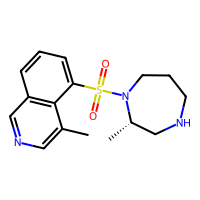

In [11]:
# Subset for PDB structures in ABAminus conformation only
abaminus = kinase_conf_df[(kinase_conf_df['Dihedral_Label'] == 'ABAminus') & (kinase_conf_df['Dataset'] == 'PDB')]
# Read in more information
PDB_df = pd.read_excel('Data/PDB/PDB_PKA_StructuralDetails_Ligands.xlsx').rename(columns={'PDB_ID':'Structure'})
# and merge with abaminus dataframe, based on PDB_ID 
abaminus = abaminus.merge(PDB_df, how='left', on='Structure')
# Draw molecules
PandasTools.AddMoleculeColumnToFrame(abaminus, smilesCol="Lig_SMILES", molCol='2D_Mol')
PandasTools.RenderImagesInAllDataFrames(True)

print(f"{len(abaminus)} PDB Structures are in the ABAMinus conformation, namely")
print(*list(abaminus['Structure'].unique()))

ligands = list(abaminus['Lig_ID'].unique())
print(f"with {len(ligands)}] different ligands, namely {ligands}")

abaminus.to_excel('Analysis/Kinase_Conformation/ABAMinus_Structures.xlsx', index=False, header=True)

# Write to .sdf file
PandasTools.WriteSDF(abaminus,                        # DataFrame to store as .sdf file
                     "Analysis/Kinase_Conformation/ABAMinus_Structures.sdf",       # File path and name 
                     molColName='2D_Mol', # Define the name of the Molecule column
                     properties=list(abaminus.columns),         # Export all columns
                     )

abaminus.head(1)

In [12]:
# How many are of them were obtained from soaking?
# print(len(abaminus))
abaminus['Cryst_Technique'].value_counts()

Cryst_Technique
co-crystallized    20
soaked              6
Name: count, dtype: int64

['3AMB' '3ZO2' '3ZO3' '4AXA' '4C37' '5N3D']


,Structure,Dataset,Chain,Spatial_Label,Dihedral_Label,C_Helix_Label,Lig_ID,Lig_Entity_ID,Lig_Name,Lig_Formula,Lig_SMILES,Lig_MW,Lig_ChEMBL_ID,Lig_DrugBank_ID,Occurence,Lig_SMILES_Uncharged,Lig_Conformer,Lig_Of_Interest,Lig_Completeness,Lig_Occupancy,Lig_RSCC,Lig_RSR,Lig_RMSZ_Bonds,Lig_RMSZ_Angles,Lig_Alt_Conf,Title,Nonpolymer_Entity_Count,Protein_Entity_Count,Exp_Method,Cryst_Method,Deposit_Date,Resolution,DOI,Source_Organism,R_Free,Keywords,REMARK_280,REMARK_610,pH,Cryst_Technique,Sequence,Sequence_Length,Mutation_Count,Gene_Name,MW,Name,Mutations,EC_Number,Peptidic_Inhibitor,Lig_Missing_Atoms,PDBbind_Resolution,PDBbind_Release_Year,PDBbind_Comment,PDBbind_Uniprot_Id,PDBbind_Protein_Name,PDBbind_-Logkd/Ki,PDBbind_Kd/Ki,PDBbind_Kd_Or_Ki_Or_Ic50,PDBbind_Relation,PDBbind_Value,PDBbind_Unit,PDBbind_Standard_Value,PDBbind_Standard_Unit,2D_Mol
0,3AMB,PDB,A,DFGin,ABAminus,Chelix-in,VX6,3AMB_3,CYCLOPROPANECARBOXYLIC ACID {4-[4-(4-METHYL-PIPERAZIN-1-YL)-6-(5-METHYL-2H-PYRAZOL-3-YLAMINO)-PYRIMIDIN-2-YLSULFANYL]-PHENYL}-AMIDE,C23H28N8OS,Cc1cc([nH]n1)Nc2cc(nc(n2)Sc3ccc(cc3)NC(=O)C4CC4)N5CCN(CC5)C,464.586,['CHEMBL572878'],NaN,1,Cc1cc(Nc2cc(N3CCN(C)CC3)nc(Sc3ccc(NC(=O)C4CC4)cc3)n2)[nH]n1,['NaN'],['Y'],[1.0],[1.0],[0.956],[0.089],[1.79],[1.83],0,Protein kinase A sixfold mutant model of Aurora B with inhibitor VX-680,1,2,X-Ray Diffraction,"Vapor Diffusion, Hanging Drop; 25Mm Tris-Hcl, 25Mm Nacl, 1.5Mm Octanoyl-N-Methylglucamide, 1Mm (5-24)-Pki, 12-20% (V/V) Methanol, 2-Methyl-2,4-Pentanediol 30%, pH 7.5, Vapor Diffusion, Hanging Drop, Temperature 277K",2010-08-18,2.25,https://doi.org/10.1042/BJ20110592,Homo sapiens,0.25622,Transferase/Transferase Inhibitor,"Crystal Solvent Content, Vs (%): 51.83 Matthews Coefficient, Vm (Angstroms**3/Da): 2.55 Crystallization Conditions: 25Mm Tris-Hcl, 25Mm Nacl, 1.5Mm Octanoyl-N-Methylglucamide, 1Mm (5-24)-Pki, 12-20% (V/V) Methanol, 2-Methyl-2,4-Pentanediol 30%, pH 7.5, Vapor Diffusion, Hanging Drop, Temperature 277K",NaN,7.5,soaked,MGNAAAAKKGSEQESVKEFLAKAKEDFLKKWESPAQNTAHLDQFERIRTLGTGSFGRVMLVKHKETGNHYAMKILDKQKVVKLKQIEHTLNEKRIQQAVNFPFLVKLEFSFKDNSNLYMVLEYAPGGEMFSHLRRIGRFSEPHARFYAAQIVLTFEYLHSLDLIYRDLKPENLLIDQQGYIKVADFGFAKRVKGRTWTLCGTPEYLAPEIILSKGYNKAVDWWALGVLIYEMAAGYPPFFADQPIQIYEKIVSGKVRFPSHFSSDLKDLLRNLLQVDLTKRFGNLKNGVNDIKNHKWFATTDWIAIYQRKVEAPFIPKFKGPGDTSNFDDYEEEEIRVSINEKCGKEFSEF,351,6,PKACA,40.856,cAMP-Dependent Protein Kinase Catalytic Subunit Alpha,"K47R, L95Q, M120L, V123A, Q181K, T183A",2.7.11.11,True,['No'],2.25,2011.0,NaN,P17612,"CAMP-DEPENDENT PROTEIN KINASE, ALPHA-CATALYTIC",6.18,Ki=0.66uM,Ki,=,0.66,uM,660.0,nM,
1,3ZO2,PDB,A,DFGin,ABAminus,Chelix-in,15I,3ZO2_3,"6-(2,9-Diazaspiro[5.5]undecan-9-yl)-9H-purine",C14H20N6,c1[nH]c2c(n1)c(ncn2)N3CCC4(CCCNC4)CC3,272.349,['CHEMBL2420911'],NaN,1,c1nc(N2CCC3(CCCNC3)CC2)c2nc[nH]c2n1,['NaN'],['Y'],[1.0],[1.0],[0.974],[0.087],[1.75],[1.45],0,The Synthesis and Evaluation of Diazaspirocyclic Protein Kinase Inhibitors,4,2,X-Ray Diffraction,"NaN; 25Mm Mes-Bistris pH6.5, 75Mm Licl, 1Mm Dtt, 0.1Mm Edta, 1.5Mm Mega8; 4 Degree Celsius",2013-02-20,1.98,https://doi.org/10.1016/j.bmc.2013.07.021,Bos taurus,0.19090,Transferase/Inhibitor,"Crystal Solvent Content, Vs (%): 54.53 Matthews Coefficient, Vm (Angstroms**3/Da): 2.70 Crystallization Conditions: 25Mm Mes-Bistris pH6.5, 75Mm Licl, 1Mm Dtt, 0.1Mm Edta, 1.5Mm Mega8; 4 Degree Celsius, Temperature 277K",NaN,6.5,soaked,MGNAAAAKKGSEQESVKEFLAKAKEDFLKKWENPAQNTAHLDQFERIKTLGTGSFGRVMLVKHMETGNHYAMKILDKQKVVKLKQIEHTLNEKRILQAVNFPFLVKLEFSFKDNSNLYMVMEYVPGGEMFSHLRRIGRFSEPHARFYAAQIVLTFEYLHSLDLIYRDLKPENLLIDQQGYIQVTDFGFAKRVKGRTWTLCGTPEYLAPEIILSKGYNKAVDWWALGVLIYEMAAGYPPFFADQPIQIYEKIVSGKVRFPSHFSSDLKDLLRNLLQVDLTKRFGNLKNGVNDIKNHKWFATTDWIAIYQRKVEAPFIPKFKGPGDTSNFDDYEEEEIRVSINEKCGKEFSEF,351,0,NaN,40.998,cAMP-Dependent Protein Kinase Catalytic Subunit Alpha,NaN,2.7.11.11,True,['No'],1.98,2013.0,ligand is compound 14,P00517,"CAMP-DEPENDENT PROTEIN KINASE, ALPHA-CATALYTIC",7.10,IC=80nM,IC50,=,80.00,nM,80.0,nM,
2,3ZO3,PDB,A,DFGin,ABAminus,Chelix-in,QNI
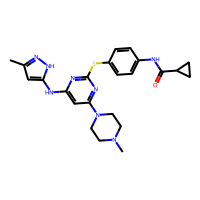
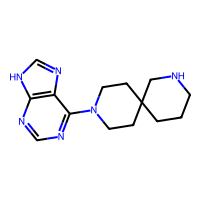
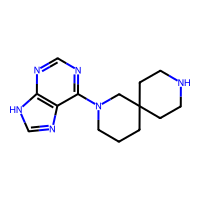
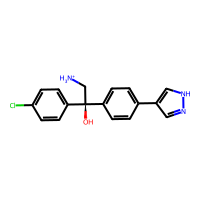
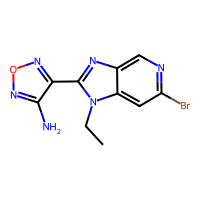
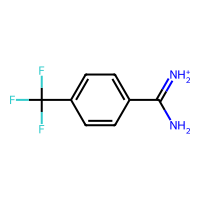

In [13]:
abaminus_soaked = abaminus[abaminus['Cryst_Technique'] == 'soaked'].reset_index(drop=True)
print(abaminus_soaked['Structure'].unique())
abaminus_soaked